# Installations

## Import and load packages

Install the packages that we need in order to run on Google Colab. Always check the version number because it is more recent than what was used in the book. Version mismatch may or may not be a problem.

In [1]:
import sklearn

print(sklearn.__version__)

1.6.1


Google Colab does not have PennyLane by default, so install it first. This should be very fast (seconds).

In [2]:
pip install pennylane

In [3]:
import pennylane as qml

print(qml.__version__)

/usr/local/lib/python3.11/dist-packages/pennylane/capture/capture_operators.py:33: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.4.28. You have version 0.5.2 installed. Please downgrade JAX to <=0.4.28 to avoid runtime errors.
  warnings.warn(


0.41.1


Import numpy and set a seed for reproducibility.

In [4]:
import numpy as np

seed = 1234
np.random.seed(seed)

In [5]:
import matplotlib.pyplot as plt

## Import and visualize the dataset

Import the wine dataset:

https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html

In [6]:
from sklearn.datasets import load_wine

x_original,y_original = load_wine(return_X_y = True)

The dataset has three wine categories:


*   Class_0: 59 elements
*   Class_1: 71 elements
*   Class_2: 48 elements

To turn this into a binary classification problem, ignore Class_2 and keep only Class_0 and Class_1:

In [7]:
x = x_original[:59+71]
y = y_original[:59+71]

Be careful that the elements in the dataset are not randomized:

In [8]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

Let's illustrate the 13 features for the original three classes:

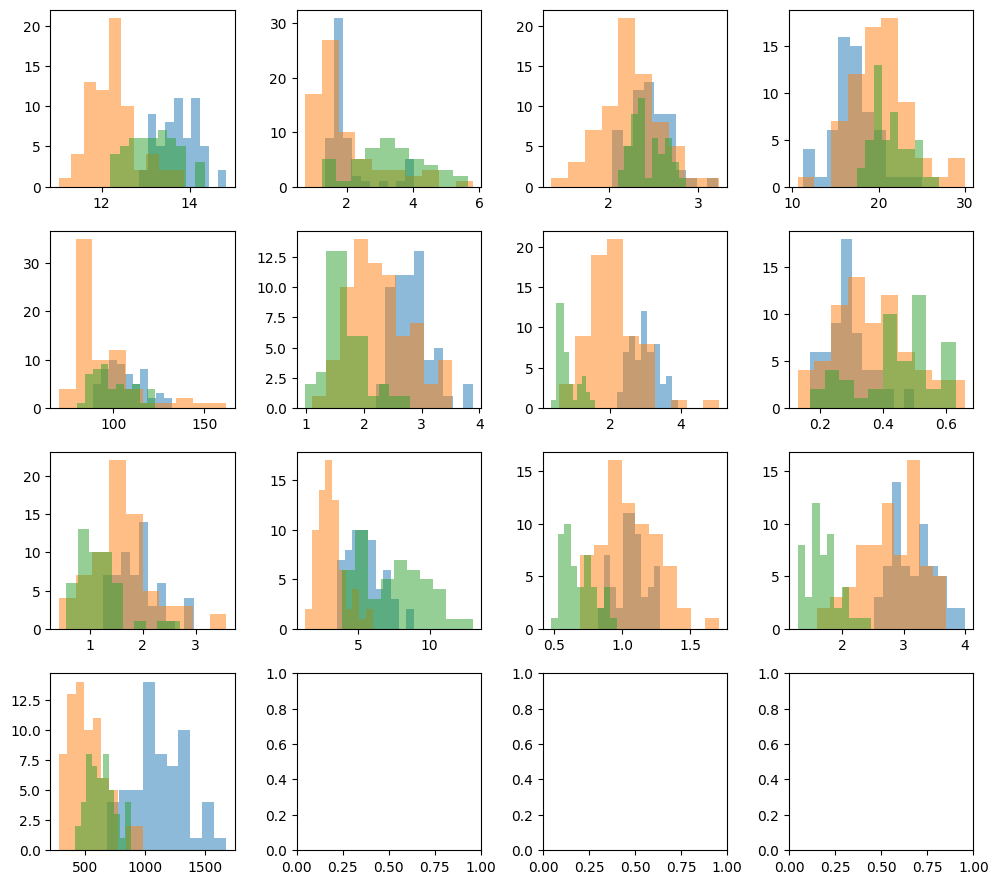

In [9]:
fig = plt.subplots(4,4,figsize=(10,9))
plt.tight_layout()

for i in range(13):
    plt.subplot(4,4,i+1)
    plt.hist(x_original[:59,i], alpha=0.5)
    plt.hist(x_original[59:130,i], alpha=0.5)
    plt.hist(x_original[130:,i], alpha=0.5)

Just the two classes we are considering:

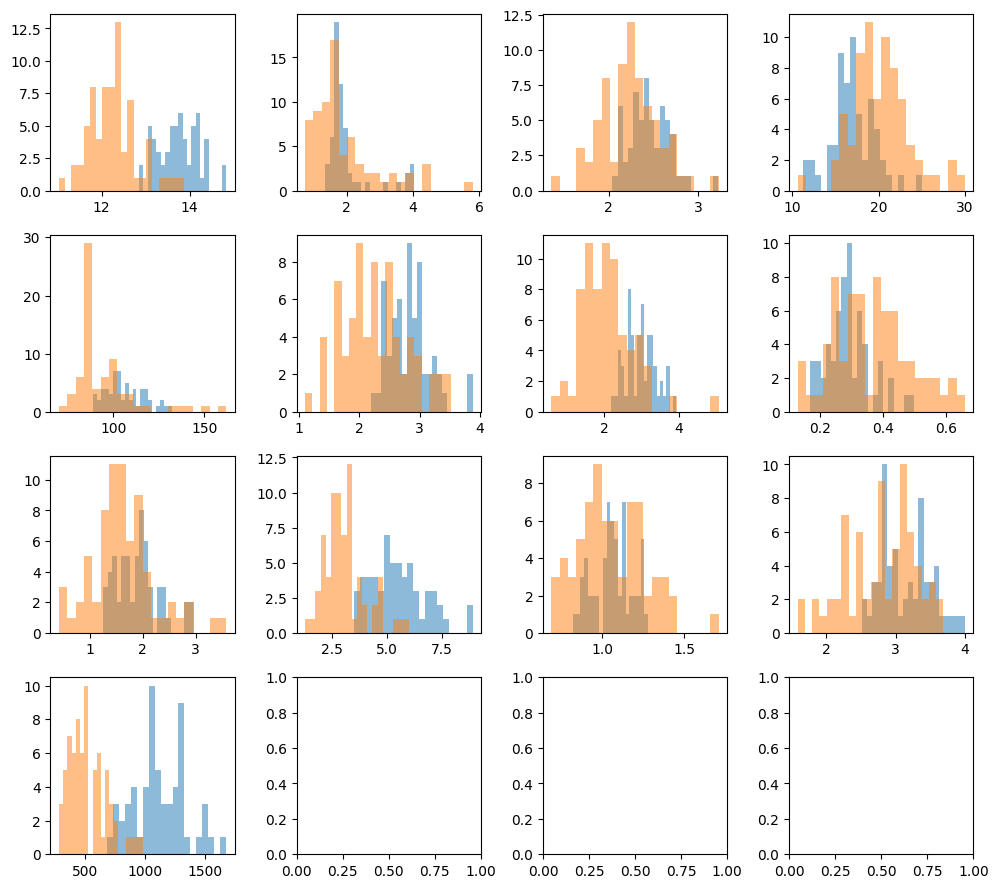

In [10]:
fig = plt.subplots(4,4,figsize=(10,9))
plt.tight_layout()

for i in range(13):
    plt.subplot(4,4,i+1)
    plt.hist(x[:59,i], bins=20, alpha=0.5)
    plt.hist(x[59:,i], bins=20, alpha=0.5)

## Preprocess the data

Create a train-test split 90:10.

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.9)

Feature maps expect the features to be normalized. Here we use the MaxAbsScaler but other options are also possible. Note that the scaler is fitted to the training data only to avoid contamination from the testing data.

In [12]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
x_tr = scaler.fit_transform(x_train)
y_tr = y_train

Check the features after rescaling:

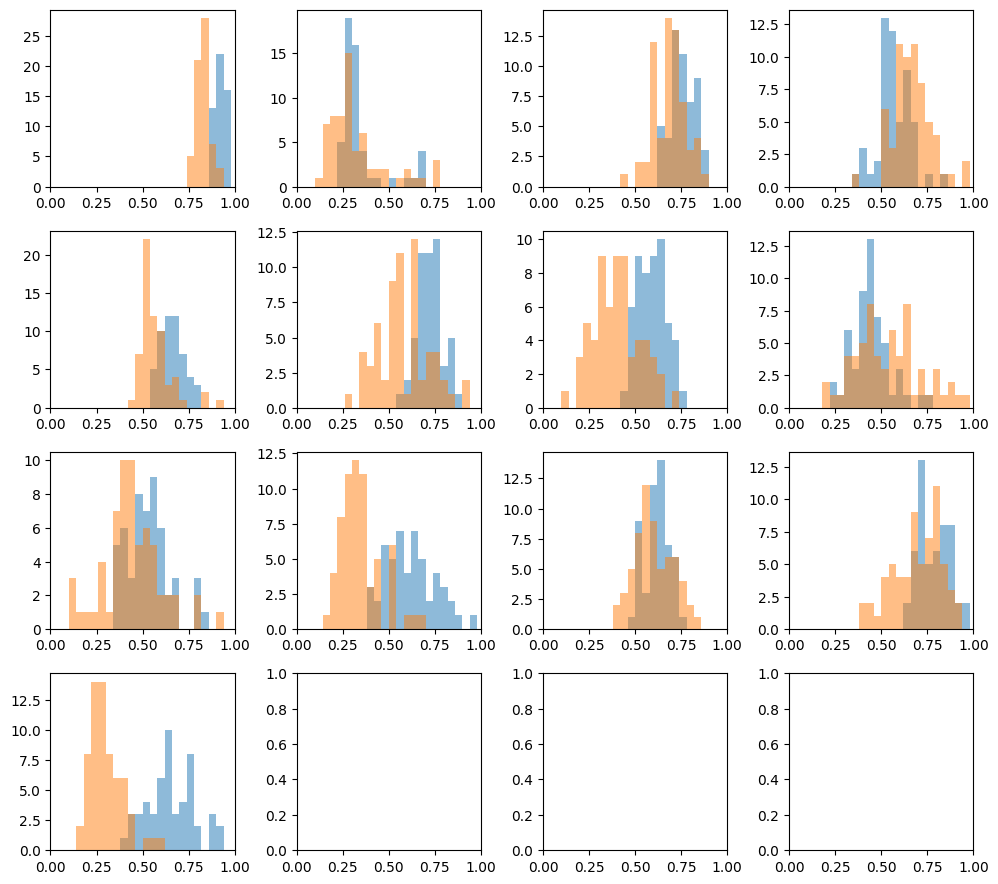

In [13]:
fig = plt.subplots(4,4,figsize=(10,9))
plt.tight_layout()

ind0 = np.where(y_tr == 0)[0]
ind1 = np.where(y_tr == 1)[0]

for i in range(13):
    plt.subplot(4,4,i+1)
    plt.hist(x_tr[ind0,i], bins=np.linspace(0.02,0.98,25), alpha=0.5)
    plt.hist(x_tr[ind1,i], bins=np.linspace(0.02,0.98,25), alpha=0.5)
    plt.xlim(0,1)


Now also transform the testing data with the already trained scaler.

In [14]:
x_test = scaler.transform(x_test)

Check if there are any values outside the (0,1) range:

In [15]:
for i in range(13):
    print(i, np.min(x_test[:,i]), np.max(x_test[:,i]))

0 0.7855697909642616 0.9703304113283885
1 0.1706896551724138 0.6672413793103449
2 0.5263157894736842 0.9040247678018576
3 0.48666666666666664 0.8666666666666667
4 0.5432098765432098 0.8395061728395061
5 0.45103092783505155 0.8711340206185567
6 0.3169291338582677 0.7007874015748031
7 0.19696969696969696 0.9090909090909091
8 0.2877094972067039 0.770949720670391
9 0.2887640449438202 0.7022471910112359
10 0.5146198830409356 0.847953216374269
11 0.5575 0.895
12 0.2113095238095238 0.7678571428571429


In [16]:
x_test.shape

(13, 13)

Everybody is in the correct range. If there were points outside the range we can drop them with the command below.

In [17]:
x_test = np.clip(x_test,0,1)
x_test.shape

(13, 13)

# QSVM model number 1

Encode all of the original 13 features using amplitude embedding on 4 qubits. It can handle up to 16 features, so we pad the last 3 with zeros.

In [18]:
nqubits = 4
dev = qml.device("lightning.qubit", wires = nqubits)

@qml.qnode(dev)
def kernel_circ(a, b):
    qml.AmplitudeEmbedding(
        a, wires=range(nqubits), pad_with=0, normalize=True)
    qml.adjoint(qml.AmplitudeEmbedding(
        b, wires=range(nqubits), pad_with=0, normalize=True))
    return qml.probs(wires = range(nqubits))

Check that you get 1 for the first entry if the element is the same:

In [19]:
kernel_circ(x_tr[100], x_tr[100])

array([1.00000000e+00, 2.01353805e-34, 2.36465276e-33, 4.56498184e-33,
       4.99541485e-33, 1.52052806e-33, 7.40435020e-34, 1.09114906e-33,
       1.02018280e-32, 9.93895765e-34, 1.16810738e-33, 6.74551424e-34,
       1.95352043e-34, 3.29129299e-34, 4.35515180e-34, 3.72399006e-34])

Run SVC with the custom quantum kernel. (The training takes 70 seconds on Google Colab.)

In [20]:
from sklearn.svm import SVC
def qkernel(A, B):
    return np.array([[kernel_circ(a, b)[0] for b in B] for a in A])

svm = SVC(kernel = qkernel).fit(x_tr, y_tr)

Check the performance:

In [21]:
from sklearn.metrics import accuracy_score

print(accuracy_score(svm.predict(x_test), y_test))

0.9230769230769231


The book says 0.92. Done.

# QSVM model number 2

Now repeat the exercise but first do dimensionality reduction of the data using PCA. Reduce to the first 8 principal components. This allows the use of angular encoding on 8 qubits later.

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 8)

xs_tr = pca.fit_transform(x_tr)
xs_test = pca.transform(x_test)

Now do angular embedding on 8 qubits, unlike the previous case.

In [23]:
nqubits = 8
dev = qml.device("lightning.qubit", wires=nqubits)

@qml.qnode(dev)
def kernel_circ(a, b):
    qml.AngleEmbedding(a, wires=range(nqubits))
    qml.adjoint(qml.AngleEmbedding(b, wires=range(nqubits)))
    return qml.probs(wires = range(nqubits))

The training takes 39 seconds.

In [24]:
svm = SVC(kernel = qkernel).fit(xs_tr, y_tr)

print(accuracy_score(svm.predict(xs_test), y_test))

1.0


Perfect classification, as in the book.

# QSVM model number 3

Now use a different feature map. PennyLane comes with several prebuilt embedding templates:

https://docs.pennylane.ai/en/stable/introduction/templates.html

Here we illustrate a custom-made feature map.

In [25]:
from itertools import combinations

def ZZFeatureMap(nqubits, data):

    # Number of variables that we will load:
    # could be smaller than the number of qubits.
    nload = min(len(data), nqubits)

    for i in range(nload):
        qml.Hadamard(i)
        qml.RZ(2.0 * data[i], wires = i)

    for pair in list(combinations(range(nload), 2)):
        q0 = pair[0]
        q1 = pair[1]

        qml.CZ(wires = [q0, q1])
        qml.RZ(2.0 * (np.pi - data[q0]) *
            (np.pi - data[q1]), wires = q1)
        qml.CZ(wires = [q0, q1])

The training takes 75 seconds.

In [26]:
nqubits = 4
dev = qml.device("lightning.qubit", wires = nqubits)

@qml.qnode(dev)
def kernel_circ(a, b):
    ZZFeatureMap(nqubits, a)
    qml.adjoint(ZZFeatureMap)(nqubits, b)
    return qml.probs(wires = range(nqubits))

svm = SVC(kernel=qkernel).fit(xs_tr, y_tr)
print(accuracy_score(svm.predict(xs_test), y_test))

0.8461538461538461


# Epilogue

Old school scatter plot of the best two original features.

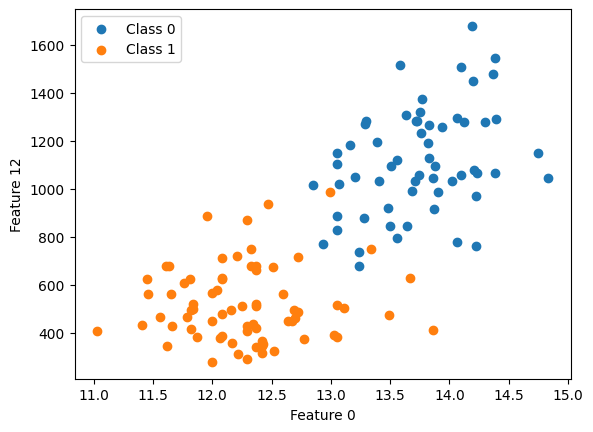

In [27]:
plt.scatter(x_original[:59,0], x_original[:59,12], label='Class 0')
plt.scatter(x_original[59:130,0], x_original[59:130,12], label='Class 1')
plt.legend()
plt.xlabel('Feature 0')
plt.ylabel('Feature 12')
plt.show()